# Python LAB - Natural Language Processing in Finance [2.2]

## 0 - Packages

### Installing Packages

In [142]:
%pip install yfinance --upgrade --no-cache-dir
%pip install htmldate
%pip install twython
%pip install newspaper3k
%pip install seaborn
%pip install textblob

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Importing Libraries

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns
import math
import datetime
import re
import yfinance as yf
import nltk
import warnings
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
from textblob import TextBlob

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchmetrics import (MeanAbsoluteError,
                          R2Score)
from torchinfo import summary
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)
from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
                                ResNet50_Weights)
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)
from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marco/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Seed set to 0


## 1 -  Data Importing and Preprocessing

### 1.1 Importing News data

In [144]:
Shell = pd.read_csv('Shell_articles.csv', header=0)
Shell = Shell.drop('Unnamed: 0.1', axis=1)
Shell = Shell.drop('Unnamed: 0', axis=1)
Shell

,ticker,publish_date,title,body_text,url,neg,neu,pos,compound
0,SHEL,2024-01-16,Shell to exit Nigeria's troubled onshore oil a...,"Published Jan 16, 2024 09:30 Updated Jan 16, 2...",https://uk.investing.com//news/commodities-new...,0.078,0.843,0.079,-0.2073
1,SHEL,2024-02-01,"European stocks weaken ahead of BOE, eurozone ...","Published Feb 01, 2024 08:24\n\n© Reuters.\n\n...",https://uk.investing.com//news/stock-market-ne...,0.064,0.852,0.083,0.9469
2,SHEL,2024-01-29,FTSE 100 Live: Stocks in the green supported b...,"Published Jan 29, 2024 10:45 Updated Jan 29, 2...",https://uk.investing.com//news/stock-market-ne...,0.103,0.802,0.095,-0.5170
3,SHEL,2023-11-08,FTSE 100 sees minor decline amidst robust reta...,"Published Nov 08, 2023 17:48\n\n© Reuters.\n\n...",https://uk.investing.com//news/stock-market-ne...,0.029,0.842,0.129,0.9874
4,SHEL,2023-11-08,FTSE 100 sees minor decline amidst robust reta...,"Published Nov 08, 2023 17:48\n\n© Reuters.\n\n...",https://uk.investing.com//news/stock-market-ne...,0.029,0.842,0.129,0.9874
...,...,...,...,...,...,...,...,...,...
986,SHEL,2019-07-19,Icahn launches proxy fight after stalled talks...,"Published Jul 19, 2019 01:37\n\nSHEL +0.44% Ad...",https://uk.investing.com//news/stock-market-ne...,0.044,0.869,0.087,0.9467
987,SHEL,2019-07-17,"Investing £2,000 in a Stocks and Shares ISA? I...","Published Jul 17, 2019 15:16 Updated Jul 17, 2...",https://uk.investing.com//news/stock-market-ne...,0.068,0.752,0.180,0.9980
988,SHEL,2019-07-17,"Oil majors drag FTSE lower, Galliford leads mi...","Published Jul 17, 2019 17:25\n\n© Reuters. Tra...",https://uk.investing.com//news/stock-market-ne...,0.051,0.874,0.075,0.9086
989,SHEL,2019-07-19,These 3 FTSE 100 dividend stocks could boom in...,"Published Jul 19, 2019 08:12 Updated Jul 19, 2...",https://uk.investing.com//news/stock-market-ne...,0.086,0.816,0.098,0.6623


### 1.2 Cleaning Articles Data

In [145]:
article_sentiments_shell = Shell.copy()
article_sentiments_shell.head(4)

,ticker,publish_date,title,body_text,url,neg,neu,pos,compound
0,SHEL,2024-01-16,Shell to exit Nigeria's troubled onshore oil a...,"Published Jan 16, 2024 09:30 Updated Jan 16, 2...",https://uk.investing.com//news/commodities-new...,0.078,0.843,0.079,-0.2073
1,SHEL,2024-02-01,"European stocks weaken ahead of BOE, eurozone ...","Published Feb 01, 2024 08:24\n\n© Reuters.\n\n...",https://uk.investing.com//news/stock-market-ne...,0.064,0.852,0.083,0.9469
2,SHEL,2024-01-29,FTSE 100 Live: Stocks in the green supported b...,"Published Jan 29, 2024 10:45 Updated Jan 29, 2...",https://uk.investing.com//news/stock-market-ne...,0.103,0.802,0.095,-0.5170
3,SHEL,2023-11-08,FTSE 100 sees minor decline amidst robust reta...,"Published Nov 08, 2023 17:48\n\n© Reuters.\n\n...",https://uk.investing.com//news/stock-market-ne...,0.029,0.842,0.129,0.9874


In order to prepare the data for further processing a separator to the body text of each article is indluded to simplify identification in the next steps:

In [146]:
article_sentiments_shell['body_text'] = article_sentiments_shell['body_text'].astype(str) + '---newarticle---'

In [147]:
shell_bodytext = article_sentiments_shell['body_text']
#pd.set_option("display.max_colwidth", -1)  # to display full text
shell_bodytext

0      Published Jan 16, 2024 09:30 Updated Jan 16, 2...
1      Published Feb 01, 2024 08:24\n\n© Reuters.\n\n...
2      Published Jan 29, 2024 10:45 Updated Jan 29, 2...
3      Published Nov 08, 2023 17:48\n\n© Reuters.\n\n...
4      Published Nov 08, 2023 17:48\n\n© Reuters.\n\n...
                             ...                        
986    Published Jul 19, 2019 01:37\n\nSHEL +0.44% Ad...
987    Published Jul 17, 2019 15:16 Updated Jul 17, 2...
988    Published Jul 17, 2019 17:25\n\n© Reuters. Tra...
989    Published Jul 19, 2019 08:12 Updated Jul 19, 2...
990    Published Jul 19, 2019 13:28\n\n© Reuters. FIL...
Name: body_text, Length: 991, dtype: object

In [148]:
# Save sentiment to txt

with open('shell_bodytext_lab.txt', 'w') as f:
    f.write(
        shell_bodytext.to_string(header = False, index = False)
    )

#### Drop rows without publish date

In [149]:
article_sentiments_shell = article_sentiments_shell.replace(to_replace='None', value=np.nan).dropna()
article_sentiments_shell

,ticker,publish_date,title,body_text,url,neg,neu,pos,compound
0,SHEL,2024-01-16,Shell to exit Nigeria's troubled onshore oil a...,"Published Jan 16, 2024 09:30 Updated Jan 16, 2...",https://uk.investing.com//news/commodities-new...,0.078,0.843,0.079,-0.2073
1,SHEL,2024-02-01,"European stocks weaken ahead of BOE, eurozone ...","Published Feb 01, 2024 08:24\n\n© Reuters.\n\n...",https://uk.investing.com//news/stock-market-ne...,0.064,0.852,0.083,0.9469
2,SHEL,2024-01-29,FTSE 100 Live: Stocks in the green supported b...,"Published Jan 29, 2024 10:45 Updated Jan 29, 2...",https://uk.investing.com//news/stock-market-ne...,0.103,0.802,0.095,-0.5170
3,SHEL,2023-11-08,FTSE 100 sees minor decline amidst robust reta...,"Published Nov 08, 2023 17:48\n\n© Reuters.\n\n...",https://uk.investing.com//news/stock-market-ne...,0.029,0.842,0.129,0.9874
4,SHEL,2023-11-08,FTSE 100 sees minor decline amidst robust reta...,"Published Nov 08, 2023 17:48\n\n© Reuters.\n\n...",https://uk.investing.com//news/stock-market-ne...,0.029,0.842,0.129,0.9874
...,...,...,...,...,...,...,...,...,...
986,SHEL,2019-07-19,Icahn launches proxy fight after stalled talks...,"Published Jul 19, 2019 01:37\n\nSHEL +0.44% Ad...",https://uk.investing.com//news/stock-market-ne...,0.044,0.869,0.087,0.9467
987,SHEL,2019-07-17,"Investing £2,000 in a Stocks and Shares ISA? I...","Published Jul 17, 2019 15:16 Updated Jul 17, 2...",https://uk.investing.com//news/stock-market-ne...,0.068,0.752,0.180,0.9980
988,SHEL,2019-07-17,"Oil majors drag FTSE lower, Galliford leads mi...","Published Jul 17, 2019 17:25\n\n© Reuters. Tra...",https://uk.investing.com//news/stock-market-ne...,0.051,0.874,0.075,0.9086
989,SHEL,2019-07-19,These 3 FTSE 100 dividend stocks could boom in...,"Published Jul 19, 2019 08:12 Updated Jul 19, 2...",https://uk.investing.com//news/stock-market-ne...,0.086,0.816,0.098,0.6623


#### Dropping duplicates

In [150]:
article_sentiments_shell.drop_duplicates(subset ="title", keep = 'first', inplace = True)
article_sentiments_shell

,ticker,publish_date,title,body_text,url,neg,neu,pos,compound
0,SHEL,2024-01-16,Shell to exit Nigeria's troubled onshore oil a...,"Published Jan 16, 2024 09:30 Updated Jan 16, 2...",https://uk.investing.com//news/commodities-new...,0.078,0.843,0.079,-0.2073
1,SHEL,2024-02-01,"European stocks weaken ahead of BOE, eurozone ...","Published Feb 01, 2024 08:24\n\n© Reuters.\n\n...",https://uk.investing.com//news/stock-market-ne...,0.064,0.852,0.083,0.9469
2,SHEL,2024-01-29,FTSE 100 Live: Stocks in the green supported b...,"Published Jan 29, 2024 10:45 Updated Jan 29, 2...",https://uk.investing.com//news/stock-market-ne...,0.103,0.802,0.095,-0.5170
3,SHEL,2023-11-08,FTSE 100 sees minor decline amidst robust reta...,"Published Nov 08, 2023 17:48\n\n© Reuters.\n\n...",https://uk.investing.com//news/stock-market-ne...,0.029,0.842,0.129,0.9874
5,SHEL,2024-01-31,"Labour would 'unashamedly champion' City, says...","Published Jan 31, 2024 09:35 Updated Jan 31, 2...",https://uk.investing.com//news/stock-market-ne...,0.026,0.851,0.123,0.9834
...,...,...,...,...,...,...,...,...,...
986,SHEL,2019-07-19,Icahn launches proxy fight after stalled talks...,"Published Jul 19, 2019 01:37\n\nSHEL +0.44% Ad...",https://uk.investing.com//news/stock-market-ne...,0.044,0.869,0.087,0.9467
987,SHEL,2019-07-17,"Investing £2,000 in a Stocks and Shares ISA? I...","Published Jul 17, 2019 15:16 Updated Jul 17, 2...",https://uk.investing.com//news/stock-market-ne...,0.068,0.752,0.180,0.9980
988,SHEL,2019-07-17,"Oil majors drag FTSE lower, Galliford leads mi...","Published Jul 17, 2019 17:25\n\n© Reuters. Tra...",https://uk.investing.com//news/stock-market-ne...,0.051,0.874,0.075,0.9086
989,SHEL,2019-07-19,These 3 FTSE 100 dividend stocks could boom in...,"Published Jul 19, 2019 08:12 Updated Jul 19, 2...",https://uk.investing.com//news/stock-market-ne...,0.086,0.816,0.098,0.6623


#### Set Datetime format index

In [151]:
article_sentiments_shell['Date'] = pd.to_datetime(article_sentiments_shell.publish_date)
article_sentiments_shell.set_index('Date', inplace=True)
article_sentiments_shell

,ticker,publish_date,title,body_text,url,neg,neu,pos,compound
Date,,,,,,,,,
2024-01-16,SHEL,2024-01-16,Shell to exit Nigeria's troubled onshore oil a...,"Published Jan 16, 2024 09:30 Updated Jan 16, 2...",https://uk.investing.com//news/commodities-new...,0.078,0.843,0.079,-0.2073
2024-02-01,SHEL,2024-02-01,"European stocks weaken ahead of BOE, eurozone ...","Published Feb 01, 2024 08:24\n\n© Reuters.\n\n...",https://uk.investing.com//news/stock-market-ne...,0.064,0.852,0.083,0.9469
2024-01-29,SHEL,2024-01-29,FTSE 100 Live: Stocks in the green supported b...,"Published Jan 29, 2024 10:45 Updated Jan 29, 2...",https://uk.investing.com//news/stock-market-ne...,0.103,0.802,0.095,-0.5170
2023-11-08,SHEL,2023-11-08,FTSE 100 sees minor decline amidst robust reta...,"Published Nov 08, 2023 17:48\n\n© Reuters.\n\n...",https://uk.investing.com//news/stock-market-ne...,0.029,0.842,0.129,0.9874
2024-01-31,SHEL,2024-01-31,"Labour would 'unashamedly champion' City, says...","Published Jan 31, 2024 09:35 Updated Jan 31, 2...",https://uk.investing.com//news/stock-market-ne...,0.026,0.851,0.123,0.9834
...,...,...,...,...,...,...,...,...,...
2019-07-19,SHEL,2019-07-19,Icahn launches proxy fight after stalled talks...,"Published Jul 19, 2019 01:37\n\nSHEL +0.44% Ad...",https://uk.investing.com//news/stock-market-ne...,0.044,0.869,0.087,0.9467
2019-07-17,SHEL,2019-07-17,"Investing £2,000 in a Stocks and Shares ISA? I...","Published Jul 17, 2019 15:16 Updated Jul 17, 2...",https://uk.investing.com//news/stock-market-ne...,0.068,0.752,0.180,0.9980
2019-07-17,SHEL,2019-07-17,"Oil majors drag FTSE lower, Galliford leads mi...","Published Jul 17, 2019 17:25\n\n© Reuters. Tra...",https://uk.investing.com//news/stock-market-ne...,0.051,0.874,0.075,0.9086


#### Sorting Dates

In [152]:
article_sentiments_shell = article_sentiments_shell.sort_index()
article_sentiments_shell

,ticker,publish_date,title,body_text,url,neg,neu,pos,compound
Date,,,,,,,,,
2019-07-17,SHEL,2019-07-17,"Oil majors drag FTSE lower, Galliford leads mi...","Published Jul 17, 2019 17:25\n\n© Reuters. Tra...",https://uk.investing.com//news/stock-market-ne...,0.051,0.874,0.075,0.9086
2019-07-17,SHEL,2019-07-17,"Investing £2,000 in a Stocks and Shares ISA? I...","Published Jul 17, 2019 15:16 Updated Jul 17, 2...",https://uk.investing.com//news/stock-market-ne...,0.068,0.752,0.180,0.9980
2019-07-17,SHEL,2019-07-17,Climate activists disrupt London concrete plan...,"Published Jul 17, 2019 21:43\n\n© Reuters. Cli...",https://uk.investing.com//news/economy-news/cl...,0.051,0.939,0.010,-0.4497
2019-07-18,SHEL,2019-07-18,UK police vow to stop repeat of Extinction Reb...,"Published Jul 18, 2019 14:40\n\n© Reuters. FIL...",https://uk.investing.com//news/commodities-new...,0.158,0.807,0.035,-0.9926
2019-07-19,SHEL,2019-07-19,UK eco-activists banned from using boats in st...,"Published Jul 19, 2019 13:28\n\n© Reuters. FIL...",https://uk.investing.com//news/world-news/uk-e...,0.170,0.801,0.029,-0.9826
...,...,...,...,...,...,...,...,...,...
2024-01-16,SHEL,2024-01-16,Shell to exit Nigeria's troubled onshore oil a...,"Published Jan 16, 2024 09:30 Updated Jan 16, 2...",https://uk.investing.com//news/commodities-new...,0.078,0.843,0.079,-0.2073
2024-01-29,SHEL,2024-01-29,FTSE 100 Live: Stocks in the green supported b...,"Published Jan 29, 2024 10:45 Updated Jan 29, 2...",https://uk.investing.com//news/stock-market-ne...,0.103,0.802,0.095,-0.5170
2024-01-31,SHEL,2024-01-31,"Labour would 'unashamedly champion' City, says...","Published Jan 31, 2024 09:35 Updated Jan 31, 2...",https://uk.investing.com//news/stock-market-ne...,0.026,0.851,0.123,0.9834


#### Combining articles of the same date

In [153]:
article_sentiments_shell['news_combined'] = article_sentiments_shell.groupby(['publish_date'])['body_text'].transform(lambda x: ' '.join(x))
article_sentiments_shell.head()

,ticker,publish_date,title,body_text,url,neg,neu,pos,compound,news_combined
Date,,,,,,,,,,
2019-07-17,SHEL,2019-07-17,"Oil majors drag FTSE lower, Galliford leads mi...","Published Jul 17, 2019 17:25\n\n© Reuters. Tra...",https://uk.investing.com//news/stock-market-ne...,0.051,0.874,0.075,0.9086,"Published Jul 17, 2019 17:25\n\n© Reuters. Tra..."
2019-07-17,SHEL,2019-07-17,"Investing £2,000 in a Stocks and Shares ISA? I...","Published Jul 17, 2019 15:16 Updated Jul 17, 2...",https://uk.investing.com//news/stock-market-ne...,0.068,0.752,0.180,0.9980,"Published Jul 17, 2019 17:25\n\n© Reuters. Tra..."
2019-07-17,SHEL,2019-07-17,Climate activists disrupt London concrete plan...,"Published Jul 17, 2019 21:43\n\n© Reuters. Cli...",https://uk.investing.com//news/economy-news/cl...,0.051,0.939,0.010,-0.4497,"Published Jul 17, 2019 17:25\n\n© Reuters. Tra..."
2019-07-18,SHEL,2019-07-18,UK police vow to stop repeat of Extinction Reb...,"Published Jul 18, 2019 14:40\n\n© Reuters. FIL...",https://uk.investing.com//news/commodities-new...,0.158,0.807,0.035,-0.9926,"Published Jul 18, 2019 14:40\n\n© Reuters. FIL..."
2019-07-19,SHEL,2019-07-19,UK eco-activists banned from using boats in st...,"Published Jul 19, 2019 13:28\n\n© Reuters. FIL...",https://uk.investing.com//news/world-news/uk-e...,0.170,0.801,0.029,-0.9826,"Published Jul 19, 2019 13:28\n\n© Reuters. FIL..."


#### Keeping only first instance per date

In [154]:
article_sentiments_shell.drop_duplicates(subset ="publish_date", keep = 'first', inplace = True)
article_sentiments_shell['news_combined'][0]

'Published Jul 17, 2019 17:25\n\n© Reuters. Traders work at their desks whilst screens show market data at CMC Markets in London\n\nUK100 -0.43% Add to/Remove from a Portfolio BATS -0.54% Add to/Remove from a Portfolio BP +0.64% Add to/Remove from a Portfolio SHEL +0.44% Add to/Remove from a Portfolio DGE -0.41% Add to/Remove from a Portfolio JMAT +0.73% Add to/Remove from a Portfolio BRBY +2.48% Add to/Remove from a Portfolio GFRD +2.99% Add to/Remove from a Portfolio FRES +1.74% Add to/Remove from a Portfolio SAGA +2.29% Add to/Remove from a Portfolio\n\nBy Shashwat Awasthi and Muvija M\n\n(Reuters) - The FTSE 100 index tumbled on Wednesday amid sharp falls in oil majors as investors priced in an overnight slide in crude to one-week lows, while downbeat trading updates knocked chemicals group Johnson Matthey and miner Fresnillo .\n\nShell (L: ) and BP (L: ) slipped 1.5% and 2.9% respectively, and were the biggest drags on the blue-chip index, pulling the FTSE 100 ( ) 0.6% lower even 

### 1.3 Importing SHEL stock Data

In [155]:
Shell_stock_df = yf.download("SHEL", start="2019-07-17", end="2024-02-05") # Set the beginnin and end dates for the articles you have
Shell_stock_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-07-17,63.759998,63.770000,63.259998,63.330002,52.534779,1833774
2019-07-18,63.169998,63.290001,62.770000,63.130001,52.368866,1873981
2019-07-19,63.250000,63.669998,63.189999,63.650002,52.800224,2346471
2019-07-22,63.680000,63.950001,63.630001,63.900002,53.007614,1343707
2019-07-23,64.309998,64.330002,63.759998,63.790001,52.916359,1911455
...,...,...,...,...,...,...
2024-01-29,63.220001,63.410000,62.709999,63.410000,63.410000,4660680
2024-01-30,63.240002,64.050003,63.000000,63.889999,63.889999,4431459
2024-01-31,63.570000,63.755001,62.799999,62.910000,62.910000,6776727


#### Plotting Stock Data

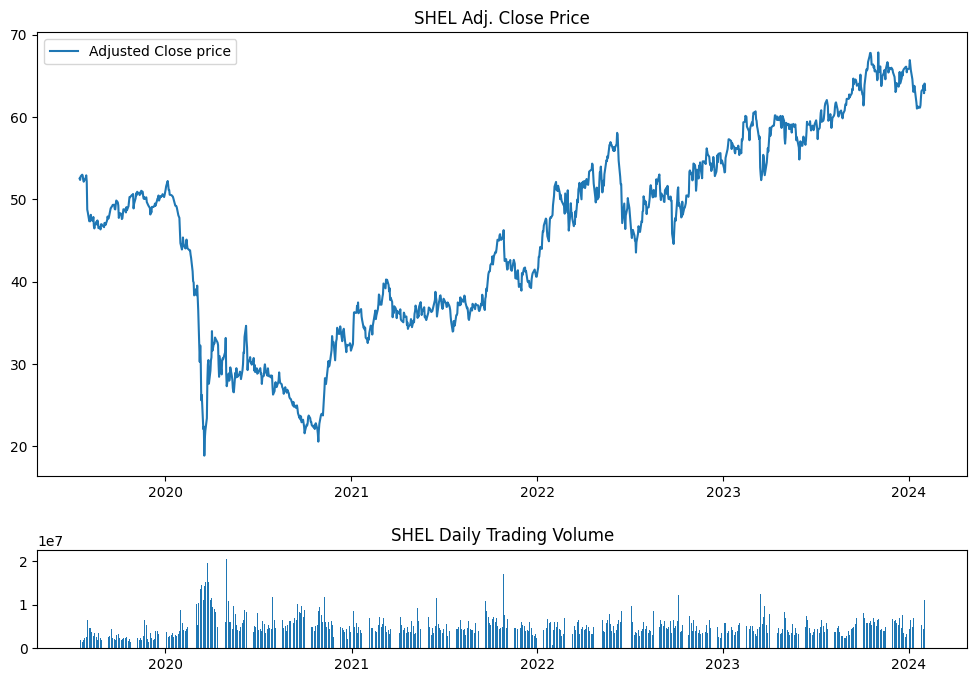

In [156]:
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4) 
top.plot(Shell_stock_df.index, Shell_stock_df['Adj Close'], label = 'Adjusted Close price') 
plt.title('SHEL Adj. Close Price') 
plt.legend(loc=2) 
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4) 
bottom.bar(Shell_stock_df.index, Shell_stock_df["Volume"]) 
plt.title('SHEL Daily Trading Volume') 
plt.gcf().set_size_inches(12,8) 
plt.subplots_adjust(hspace=0.75)

### 1.4 Merging Stock and News Data

In [157]:
Data = merge = Shell_stock_df.merge(article_sentiments_shell, how='inner', left_index=True, right_index=True)
Data.head()

,Open,High,Low,Close,Adj Close,Volume,ticker,publish_date,title,body_text,url,neg,neu,pos,compound,news_combined
Date,,,,,,,,,,,,,,,,
2019-07-17,63.759998,63.770000,63.259998,63.330002,52.534779,1833774,SHEL,2019-07-17,"Oil majors drag FTSE lower, Galliford leads mi...","Published Jul 17, 2019 17:25\n\n© Reuters. Tra...",https://uk.investing.com//news/stock-market-ne...,0.051,0.874,0.075,0.9086,"Published Jul 17, 2019 17:25\n\n© Reuters. Tra..."
2019-07-18,63.169998,63.290001,62.770000,63.130001,52.368866,1873981,SHEL,2019-07-18,UK police vow to stop repeat of Extinction Reb...,"Published Jul 18, 2019 14:40\n\n© Reuters. FIL...",https://uk.investing.com//news/commodities-new...,0.158,0.807,0.035,-0.9926,"Published Jul 18, 2019 14:40\n\n© Reuters. FIL..."
2019-07-19,63.250000,63.669998,63.189999,63.650002,52.800224,2346471,SHEL,2019-07-19,UK eco-activists banned from using boats in st...,"Published Jul 19, 2019 13:28\n\n© Reuters. FIL...",https://uk.investing.com//news/world-news/uk-e...,0.170,0.801,0.029,-0.9826,"Published Jul 19, 2019 13:28\n\n© Reuters. FIL..."
2019-07-22,63.680000,63.950001,63.630001,63.900002,53.007614,1343707,SHEL,2019-07-22,Witness tells court Eni official bribed him to...,"Published Jul 22, 2019 19:39\n\nSHEL +0.44% Ad...",https://uk.investing.com//news/commodities-new...,0.070,0.904,0.025,-0.9618,"Published Jul 22, 2019 19:39\n\nSHEL +0.44% Ad..."
2019-07-23,64.309998,64.330002,63.759998,63.790001,52.916359,1911455,SHEL,2019-07-23,Can you bank on these 2 FTSE 100 oil stocks to...,"Published Jul 23, 2019 11:40 Updated Jul 23, 2...",https://uk.investing.com//news/stock-market-ne...,0.054,0.855,0.091,0.9685,"Published Jul 23, 2019 11:40 Updated Jul 23, 2..."


### 1.5 Cleaning Data in combined news column

In [158]:
clean_news = []

for i in range(0, len(Data["news_combined"])): 
    clean_news.append(re.sub("\n", ' ', Data["news_combined"][i]))  # replace n\ with ' '
    clean_news[i] = re.sub(r'[^\w\d\s\']+', '', clean_news[i]) # remove unwanted punctuation and \'
    
Data['news_cleaned'] = clean_news

In [159]:
# Sanity Check
Data['news_cleaned'][0]

"Published Jul 17 2019 1725   Reuters Traders work at their desks whilst screens show market data at CMC Markets in London  UK100 043 Add toRemove from a Portfolio BATS 054 Add toRemove from a Portfolio BP 064 Add toRemove from a Portfolio SHEL 044 Add toRemove from a Portfolio DGE 041 Add toRemove from a Portfolio JMAT 073 Add toRemove from a Portfolio BRBY 248 Add toRemove from a Portfolio GFRD 299 Add toRemove from a Portfolio FRES 174 Add toRemove from a Portfolio SAGA 229 Add toRemove from a Portfolio  By Shashwat Awasthi and Muvija M  Reuters  The FTSE 100 index tumbled on Wednesday amid sharp falls in oil majors as investors priced in an overnight slide in crude to oneweek lows while downbeat trading updates knocked chemicals group Johnson Matthey and miner Fresnillo   Shell L  and BP L  slipped 15 and 29 respectively and were the biggest drags on the bluechip index pulling the FTSE 100   06 lower even as global oil prices recovered some ground The midcaps   dipped 02  Johnson M

In [160]:
Data

,Open,High,Low,Close,Adj Close,Volume,ticker,publish_date,title,body_text,url,neg,neu,pos,compound,news_combined,news_cleaned
Date,,,,,,,,,,,,,,,,,
2019-07-17,63.759998,63.770000,63.259998,63.330002,52.534779,1833774,SHEL,2019-07-17,"Oil majors drag FTSE lower, Galliford leads mi...","Published Jul 17, 2019 17:25\n\n© Reuters. Tra...",https://uk.investing.com//news/stock-market-ne...,0.051,0.874,0.075,0.9086,"Published Jul 17, 2019 17:25\n\n© Reuters. Tra...",Published Jul 17 2019 1725 Reuters Traders w...
2019-07-18,63.169998,63.290001,62.770000,63.130001,52.368866,1873981,SHEL,2019-07-18,UK police vow to stop repeat of Extinction Reb...,"Published Jul 18, 2019 14:40\n\n© Reuters. FIL...",https://uk.investing.com//news/commodities-new...,0.158,0.807,0.035,-0.9926,"Published Jul 18, 2019 14:40\n\n© Reuters. FIL...",Published Jul 18 2019 1440 Reuters FILE PHOT...
2019-07-19,63.250000,63.669998,63.189999,63.650002,52.800224,2346471,SHEL,2019-07-19,UK eco-activists banned from using boats in st...,"Published Jul 19, 2019 13:28\n\n© Reuters. FIL...",https://uk.investing.com//news/world-news/uk-e...,0.170,0.801,0.029,-0.9826,"Published Jul 19, 2019 13:28\n\n© Reuters. FIL...",Published Jul 19 2019 1328 Reuters FILE PHOT...
2019-07-22,63.680000,63.950001,63.630001,63.900002,53.007614,1343707,SHEL,2019-07-22,Witness tells court Eni official bribed him to...,"Published Jul 22, 2019 19:39\n\nSHEL +0.44% Ad...",https://uk.investing.com//news/commodities-new...,0.070,0.904,0.025,-0.9618,"Published Jul 22, 2019 19:39\n\nSHEL +0.44% Ad...",Published Jul 22 2019 1939 SHEL 044 Add toRem...
2019-07-23,64.309998,64.330002,63.759998,63.790001,52.916359,1911455,SHEL,2019-07-23,Can you bank on these 2 FTSE 100 oil stocks to...,"Published Jul 23, 2019 11:40 Updated Jul 23, 2...",https://uk.investing.com//news/stock-market-ne...,0.054,0.855,0.091,0.9685,"Published Jul 23, 2019 11:40 Updated Jul 23, 2...",Published Jul 23 2019 1140 Updated Jul 23 2019...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-04,67.330002,67.650002,66.320000,66.360001,66.360001,3420027,SHEL,2024-01-04,London midday: FTSE pares gains amid diverging...,"Published Jan 04, 2024 12:02 Updated Jan 04, 2...",https://uk.investing.com//news/stock-market-ne...,0.038,0.875,0.088,0.9960,"Published Jan 04, 2024 12:02 Updated Jan 04, 2...",Published Jan 04 2024 1202 Updated Jan 04 2024...
2024-01-16,62.919998,63.080002,61.750000,61.759998,61.759998,5960886,SHEL,2024-01-16,Shell to exit Nigeria's troubled onshore oil a...,"Published Jan 16, 2024 09:30 Updated Jan 16, 2...",https://uk.investing.com//news/commodities-new...,0.078,0.843,0.079,-0.2073,"Published Jan 16, 2024 09:30 Updated Jan 16, 2...",Published Jan 16 2024 0930 Updated Jan 16 2024...
2024-01-29,63.220001,63.410000,62.709999,63.410000,63.410000,4660680,SHEL,2024-01-29,FTSE 100 Live: Stocks in the green supported b...,"Published Jan 29, 2024 10:45 Updated Jan 29, 2...",https://uk.investing.com//news/stock-market-ne...,0.103,0.802,0.095,-0.5170,"Published Jan 29, 2024 10:45 Updated Jan 29, 2...",Published Jan 29 2024 1045 Updated Jan 29 2024...


## 2 - Sentiment Analysis

TextBlob is used to get subjectivity and polarity scores for the cleaned and merged news data. Polarity is a float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgement whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1] where 0 is objective and 1 is subjective.

In [161]:
# Subjectivity Function
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Polarity Function
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

In [162]:
Data['subjectivity'] = Data['news_cleaned'].apply(getSubjectivity)
Data['polarity'] = Data['news_cleaned'].apply(getPolarity)

In [163]:
Data

,Open,High,Low,Close,Adj Close,Volume,ticker,publish_date,title,body_text,url,neg,neu,pos,compound,news_combined,news_cleaned,subjectivity,polarity
Date,,,,,,,,,,,,,,,,,,,
2019-07-17,63.759998,63.770000,63.259998,63.330002,52.534779,1833774,SHEL,2019-07-17,"Oil majors drag FTSE lower, Galliford leads mi...","Published Jul 17, 2019 17:25\n\n© Reuters. Tra...",https://uk.investing.com//news/stock-market-ne...,0.051,0.874,0.075,0.9086,"Published Jul 17, 2019 17:25\n\n© Reuters. Tra...",Published Jul 17 2019 1725 Reuters Traders w...,0.409409,0.131998
2019-07-18,63.169998,63.290001,62.770000,63.130001,52.368866,1873981,SHEL,2019-07-18,UK police vow to stop repeat of Extinction Reb...,"Published Jul 18, 2019 14:40\n\n© Reuters. FIL...",https://uk.investing.com//news/commodities-new...,0.158,0.807,0.035,-0.9926,"Published Jul 18, 2019 14:40\n\n© Reuters. FIL...",Published Jul 18 2019 1440 Reuters FILE PHOT...,0.415231,0.097680
2019-07-19,63.250000,63.669998,63.189999,63.650002,52.800224,2346471,SHEL,2019-07-19,UK eco-activists banned from using boats in st...,"Published Jul 19, 2019 13:28\n\n© Reuters. FIL...",https://uk.investing.com//news/world-news/uk-e...,0.170,0.801,0.029,-0.9826,"Published Jul 19, 2019 13:28\n\n© Reuters. FIL...",Published Jul 19 2019 1328 Reuters FILE PHOT...,0.391276,0.113333
2019-07-22,63.680000,63.950001,63.630001,63.900002,53.007614,1343707,SHEL,2019-07-22,Witness tells court Eni official bribed him to...,"Published Jul 22, 2019 19:39\n\nSHEL +0.44% Ad...",https://uk.investing.com//news/commodities-new...,0.070,0.904,0.025,-0.9618,"Published Jul 22, 2019 19:39\n\nSHEL +0.44% Ad...",Published Jul 22 2019 1939 SHEL 044 Add toRem...,0.353517,0.070857
2019-07-23,64.309998,64.330002,63.759998,63.790001,52.916359,1911455,SHEL,2019-07-23,Can you bank on these 2 FTSE 100 oil stocks to...,"Published Jul 23, 2019 11:40 Updated Jul 23, 2...",https://uk.investing.com//news/stock-market-ne...,0.054,0.855,0.091,0.9685,"Published Jul 23, 2019 11:40 Updated Jul 23, 2...",Published Jul 23 2019 1140 Updated Jul 23 2019...,0.537382,0.113898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-04,67.330002,67.650002,66.320000,66.360001,66.360001,3420027,SHEL,2024-01-04,London midday: FTSE pares gains amid diverging...,"Published Jan 04, 2024 12:02 Updated Jan 04, 2...",https://uk.investing.com//news/stock-market-ne...,0.038,0.875,0.088,0.9960,"Published Jan 04, 2024 12:02 Updated Jan 04, 2...",Published Jan 04 2024 1202 Updated Jan 04 2024...,0.352311,0.121333
2024-01-16,62.919998,63.080002,61.750000,61.759998,61.759998,5960886,SHEL,2024-01-16,Shell to exit Nigeria's troubled onshore oil a...,"Published Jan 16, 2024 09:30 Updated Jan 16, 2...",https://uk.investing.com//news/commodities-new...,0.078,0.843,0.079,-0.2073,"Published Jan 16, 2024 09:30 Updated Jan 16, 2...",Published Jan 16 2024 0930 Updated Jan 16 2024...,0.311735,0.061037
2024-01-29,63.220001,63.410000,62.709999,63.410000,63.410000,4660680,SHEL,2024-01-29,FTSE 100 Live: Stocks in the green supported b...,"Published Jan 29, 2024 10:45 Updated Jan 29, 2...",https://uk.investing.com//news/stock-market-ne...,0.103,0.802,0.095,-0.5170,"Published Jan 29, 2024 10:45 Updated Jan 29, 2...",Published Jan 29 2024 1045 Updated Jan 29 2024...,0.448000,0.058667


## 3 - Features

In this phase, we'll determine if the Adjusted Close price for the following day has either increased or remained the same, labeling these occurrences as 1, or decreased, labeling them as 0. This process is crucial for developing and training machine learning classifier models aimed at predicting price movement based on sentiment analysis.

In [164]:
Shell_stock_df_label = Shell_stock_df.copy()
Shell_stock_df_label

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-07-17,63.759998,63.770000,63.259998,63.330002,52.534779,1833774
2019-07-18,63.169998,63.290001,62.770000,63.130001,52.368866,1873981
2019-07-19,63.250000,63.669998,63.189999,63.650002,52.800224,2346471
2019-07-22,63.680000,63.950001,63.630001,63.900002,53.007614,1343707
2019-07-23,64.309998,64.330002,63.759998,63.790001,52.916359,1911455
...,...,...,...,...,...,...
2024-01-29,63.220001,63.410000,62.709999,63.410000,63.410000,4660680
2024-01-30,63.240002,64.050003,63.000000,63.889999,63.889999,4431459
2024-01-31,63.570000,63.755001,62.799999,62.910000,62.910000,6776727


In [165]:
# "1" when SHEL Adj Close value rose or stayed as the same;
# "0" when SHEL Adj Close value decreased.

Shell_stock_df_label['Adj Close Next'] = Shell_stock_df_label['Adj Close'].shift(-1)
Shell_stock_df_label['Label'] = Shell_stock_df_label.apply(lambda x: 1 if (x['Adj Close Next']>= x['Adj Close']) else 0, axis =1)

Shell_stock_df_label[['Adj Close', 'Adj Close Next', 'Label']]

,Adj Close,Adj Close Next,Label
Date,,,
2019-07-17,52.534779,52.368866,0
2019-07-18,52.368866,52.800224,1
2019-07-19,52.800224,53.007614,1
2019-07-22,53.007614,52.916359,0
2019-07-23,52.916359,52.402042,0
...,...,...,...
2024-01-29,63.410000,63.889999,1
2024-01-30,63.889999,62.910000,0
2024-01-31,62.910000,64.080002,1


In [166]:
# Dropping NaN and column selection
Shell_stock_df_label = Shell_stock_df_label[['Adj Close Next', 'Label']].dropna()
Shell_stock_df_label

,Adj Close Next,Label
Date,,
2019-07-17,52.368866,0
2019-07-18,52.800224,1
2019-07-19,53.007614,1
2019-07-22,52.916359,0
2019-07-23,52.402042,0
...,...,...
2024-01-26,63.410000,1
2024-01-29,63.889999,1
2024-01-30,62.910000,0


In [167]:
# Merging to the original Dataset
Data = Shell_stock_df_label.merge(Data, how='inner', left_index=True, right_index=True)
Data

,Adj Close Next,Label,Open,High,Low,Close,Adj Close,Volume,ticker,publish_date,...,body_text,url,neg,neu,pos,compound,news_combined,news_cleaned,subjectivity,polarity
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-17,52.368866,0,63.759998,63.770000,63.259998,63.330002,52.534779,1833774,SHEL,2019-07-17,...,"Published Jul 17, 2019 17:25\n\n© Reuters. Tra...",https://uk.investing.com//news/stock-market-ne...,0.051,0.874,0.075,0.9086,"Published Jul 17, 2019 17:25\n\n© Reuters. Tra...",Published Jul 17 2019 1725 Reuters Traders w...,0.409409,0.131998
2019-07-18,52.800224,1,63.169998,63.290001,62.770000,63.130001,52.368866,1873981,SHEL,2019-07-18,...,"Published Jul 18, 2019 14:40\n\n© Reuters. FIL...",https://uk.investing.com//news/commodities-new...,0.158,0.807,0.035,-0.9926,"Published Jul 18, 2019 14:40\n\n© Reuters. FIL...",Published Jul 18 2019 1440 Reuters FILE PHOT...,0.415231,0.097680
2019-07-19,53.007614,1,63.250000,63.669998,63.189999,63.650002,52.800224,2346471,SHEL,2019-07-19,...,"Published Jul 19, 2019 13:28\n\n© Reuters. FIL...",https://uk.investing.com//news/world-news/uk-e...,0.170,0.801,0.029,-0.9826,"Published Jul 19, 2019 13:28\n\n© Reuters. FIL...",Published Jul 19 2019 1328 Reuters FILE PHOT...,0.391276,0.113333
2019-07-22,52.916359,0,63.680000,63.950001,63.630001,63.900002,53.007614,1343707,SHEL,2019-07-22,...,"Published Jul 22, 2019 19:39\n\nSHEL +0.44% Ad...",https://uk.investing.com//news/commodities-new...,0.070,0.904,0.025,-0.9618,"Published Jul 22, 2019 19:39\n\nSHEL +0.44% Ad...",Published Jul 22 2019 1939 SHEL 044 Add toRem...,0.353517,0.070857
2019-07-23,52.402042,0,64.309998,64.330002,63.759998,63.790001,52.916359,1911455,SHEL,2019-07-23,...,"Published Jul 23, 2019 11:40 Updated Jul 23, 2...",https://uk.investing.com//news/stock-market-ne...,0.054,0.855,0.091,0.9685,"Published Jul 23, 2019 11:40 Updated Jul 23, 2...",Published Jul 23 2019 1140 Updated Jul 23 2019...,0.537382,0.113898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-04,65.730003,0,67.330002,67.650002,66.320000,66.360001,66.360001,3420027,SHEL,2024-01-04,...,"Published Jan 04, 2024 12:02 Updated Jan 04, 2...",https://uk.investing.com//news/stock-market-ne...,0.038,0.875,0.088,0.9960,"Published Jan 04, 2024 12:02 Updated Jan 04, 2...",Published Jan 04 2024 1202 Updated Jan 04 2024...,0.352311,0.121333
2024-01-16,61.040001,0,62.919998,63.080002,61.750000,61.759998,61.759998,5960886,SHEL,2024-01-16,...,"Published Jan 16, 2024 09:30 Updated Jan 16, 2...",https://uk.investing.com//news/commodities-new...,0.078,0.843,0.079,-0.2073,"Published Jan 16, 2024 09:30 Updated Jan 16, 2...",Published Jan 16 2024 0930 Updated Jan 16 2024...,0.311735,0.061037
2024-01-29,63.889999,1,63.220001,63.410000,62.709999,63.410000,63.410000,4660680,SHEL,2024-01-29,...,"Published Jan 29, 2024 10:45 Updated Jan 29, 2...",https://uk.investing.com//news/stock-market-ne...,0.103,0.802,0.095,-0.5170,"Published Jan 29, 2024 10:45 Updated Jan 29, 2...",Published Jan 29 2024 1045 Updated Jan 29 2024...,0.448000,0.058667


In [168]:
# Collapse data set to keep relevant stock price and sentiment score columns only

keep_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'subjectivity', 'polarity', 'compound', 'neg',	'neu',	'pos', 'Label']
df =  Data[keep_columns]
df

,Open,High,Low,Close,Adj Close,Volume,subjectivity,polarity,compound,neg,neu,pos,Label
Date,,,,,,,,,,,,,
2019-07-17,63.759998,63.770000,63.259998,63.330002,52.534779,1833774,0.409409,0.131998,0.9086,0.051,0.874,0.075,0
2019-07-18,63.169998,63.290001,62.770000,63.130001,52.368866,1873981,0.415231,0.097680,-0.9926,0.158,0.807,0.035,1
2019-07-19,63.250000,63.669998,63.189999,63.650002,52.800224,2346471,0.391276,0.113333,-0.9826,0.170,0.801,0.029,1
2019-07-22,63.680000,63.950001,63.630001,63.900002,53.007614,1343707,0.353517,0.070857,-0.9618,0.070,0.904,0.025,0
2019-07-23,64.309998,64.330002,63.759998,63.790001,52.916359,1911455,0.537382,0.113898,0.9685,0.054,0.855,0.091,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-04,67.330002,67.650002,66.320000,66.360001,66.360001,3420027,0.352311,0.121333,0.9960,0.038,0.875,0.088,0
2024-01-16,62.919998,63.080002,61.750000,61.759998,61.759998,5960886,0.311735,0.061037,-0.2073,0.078,0.843,0.079,0
2024-01-29,63.220001,63.410000,62.709999,63.410000,63.410000,4660680,0.448000,0.058667,-0.5170,0.103,0.802,0.095,1


## 4 - Modelling

Data Splitting:

In [169]:
X = df.drop('Label', axis=1)
X = np.asarray(X)
y = np.asarray(df['Label'])

Note that for time series that the split cannot be random.

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [171]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Shapes should match!

(225, 12)
(225,)
(75, 12)
(75,)


### 4.3 Confusion Matrix Function

In [172]:
def plot_confusion_matrix(y_true, y_pred, labels=["Decrease", "Increase"], 
                          normalize=False, title=None, cmap=plt.cm.coolwarm):

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,4))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="snow" if cm[i, j] > thresh else "orange",
                    size=20)
    ax.grid(False)
    fig.tight_layout()
    return ax

### 4.4 Model Selection

In [173]:
models = {  'Logistic Regression': LogisticRegression(),
            'LinearDiscriminantAnalysis':LinearDiscriminantAnalysis(),
            'Naive Bayes':GaussianNB(),
            'SVM Classification': SVC(),
            'KNNeighborsClassifier':KNeighborsClassifier(n_neighbors=10),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=100),
            }

### 4.5 Neural Network

In [174]:
class StockModel(nn.Module):

    def __init__(self, input_size):
        super(StockModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10, 1),
            nn.Sigmoid())

    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [175]:
Stock_model = StockModel(X.shape[1])

In [176]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(y_train.astype(np.float32))
Stock_train = TensorDataset(X_train_t, Y_train_t)

In [177]:
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(y_test.astype(np.float32))
Stock_test = TensorDataset(X_test_t, Y_test_t)

In [178]:
max_num_workers = rec_num_workers()

In [179]:
Stock_dm = SimpleDataModule(Stock_train,
                          Stock_test,
                          batch_size=32,
                          num_workers=min(4, max_num_workers),
                          validation=Stock_test)

In [180]:
Stock_module = SimpleModule.classification(Stock_model, num_classes=2)

In [181]:
Stock_logger = CSVLogger('logs', name='STOCK')

In [182]:
Stock_trainer = Trainer(deterministic=True,
                        max_epochs=50,
                        log_every_n_steps=208,
                        logger=Stock_logger,
                        callbacks=[ErrorTracker()])

Stock_trainer.fit(Stock_module, datamodule=Stock_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | StockModel       | 141   
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
141       Trainable params
0         Non-trainable params
141       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 83.47it/s, v_num=7]            

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 79.29it/s, v_num=7]


## 5 - Results


-------------- Logistic Regression ---------------



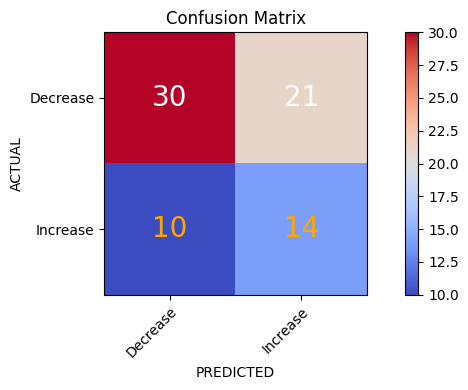

              precision    recall  f1-score   support

    Decrease       0.75      0.59      0.66        51
    Increase       0.40      0.58      0.47        24

    accuracy                           0.59        75
   macro avg       0.57      0.59      0.57        75
weighted avg       0.64      0.59      0.60        75


-------------- LinearDiscriminantAnalysis ---------------



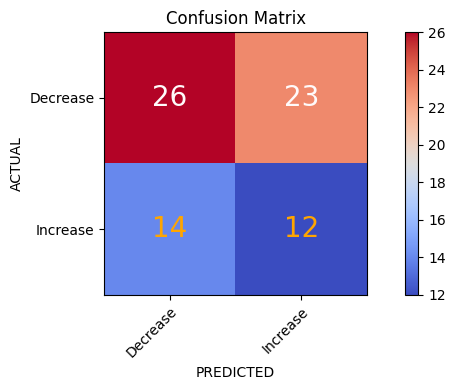

              precision    recall  f1-score   support

    Decrease       0.65      0.53      0.58        49
    Increase       0.34      0.46      0.39        26

    accuracy                           0.51        75
   macro avg       0.50      0.50      0.49        75
weighted avg       0.54      0.51      0.52        75


-------------- Naive Bayes ---------------



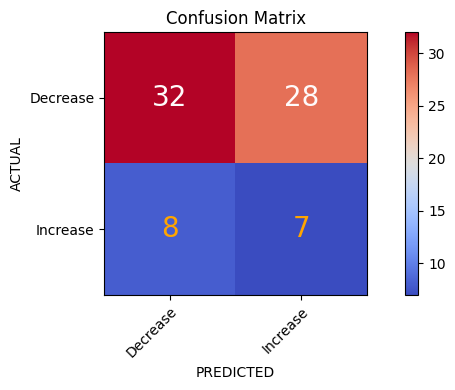

              precision    recall  f1-score   support

    Decrease       0.80      0.53      0.64        60
    Increase       0.20      0.47      0.28        15

    accuracy                           0.52        75
   macro avg       0.50      0.50      0.46        75
weighted avg       0.68      0.52      0.57        75


-------------- SVM Classification ---------------



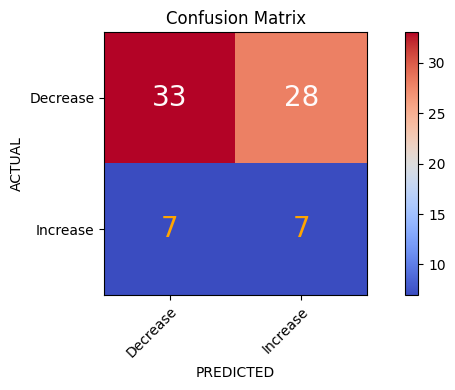

              precision    recall  f1-score   support

    Decrease       0.82      0.54      0.65        61
    Increase       0.20      0.50      0.29        14

    accuracy                           0.53        75
   macro avg       0.51      0.52      0.47        75
weighted avg       0.71      0.53      0.58        75


-------------- KNNeighborsClassifier ---------------



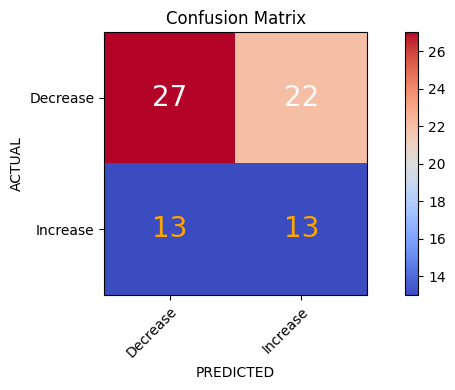

              precision    recall  f1-score   support

    Decrease       0.68      0.55      0.61        49
    Increase       0.37      0.50      0.43        26

    accuracy                           0.53        75
   macro avg       0.52      0.53      0.52        75
weighted avg       0.57      0.53      0.54        75


-------------- RandomForestClassifier ---------------



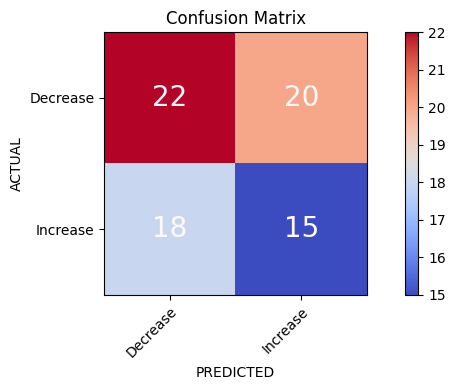

              precision    recall  f1-score   support

    Decrease       0.55      0.52      0.54        42
    Increase       0.43      0.45      0.44        33

    accuracy                           0.49        75
   macro avg       0.49      0.49      0.49        75
weighted avg       0.50      0.49      0.49        75



In [183]:
for model_name in models.keys():

    model = models[model_name]
    print('\n'+'--------------',model_name,'---------------'+'\n')
    model.fit(X_train,y_train)
    
    plot_confusion_matrix(model.predict(X_test),y_test, title="Confusion Matrix")
    np.set_printoptions(precision=1)
    plt.show()

    print(classification_report(model.predict(X_test),y_test, target_names=['Decrease', 'Increase']))

In [184]:
Stock_trainer.test(Stock_module, datamodule=Stock_dm)

Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 52.34it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.46666666865348816
        test_loss           151.11209106445312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 151.11209106445312, 'test_accuracy': 0.46666666865348816}]